## **Load Data and Imports**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
df = pd.read_csv('/content/traffic.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [4]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [5]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## **Data Cleaning**

converting DateTime column to datetime data type

In [6]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime',inplace=True)

Check For Missing Values

In [7]:
df.isnull().sum()

,0
Junction,0
Vehicles,0
ID,0


## **EDA**

Traffic trends over time

<Axes: xlabel='DateTime', ylabel='Vehicles'>

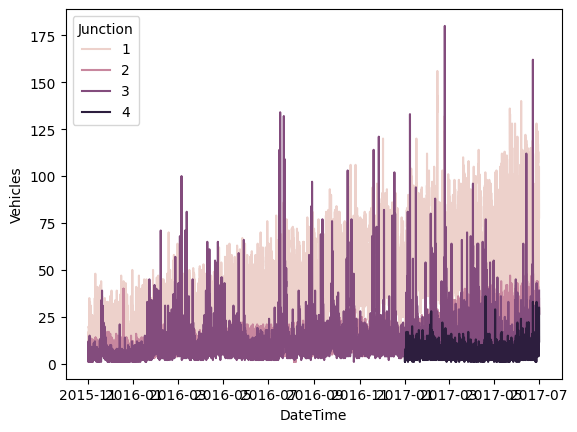

In [8]:

sns.lineplot(data=df, x=df.index, y='Vehicles', hue='Junction')


<Axes: xlabel='Junction', ylabel='Vehicles'>

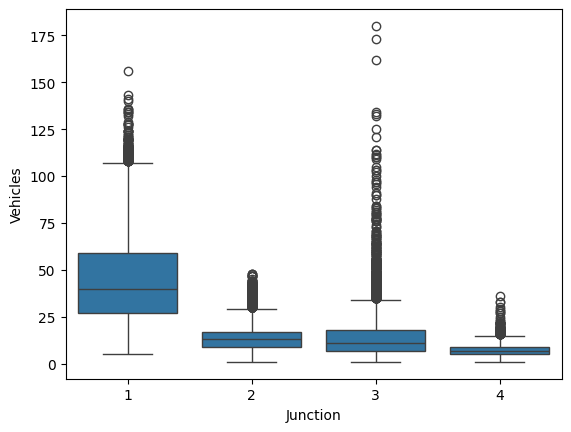

In [9]:
sns.boxplot(data=df, x='Junction', y='Vehicles')


In [11]:
df['Hour']= df.index.hour
df['Day']= df.index.day
df['Weekday']= df.index.weekday
df['Month']= df.index.month

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Vehicles_scaled'] = scaler.fit_transform(df[['Vehicles']])


## **Create Sequence for LSTM**

In [14]:
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday


In [15]:
import holidays

# Define country holidays (e.g., US)
us_holidays = holidays.US()

# Add a binary holiday column
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)


In [16]:
# Select features to include in the sequences
features = ['Vehicles_scaled', 'DayOfWeek', 'IsHoliday', 'Hour']
data = df[features].values


In [19]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length, 0]  # Target is the 'Vehicles_scaled' column
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (e.g., 24 hours)
sequence_length = 24
sequences, targets = create_sequences(data, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)


In [20]:
# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer: Predicting the scaled vehicle count

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0682 - val_loss: 0.0014
Epoch 2/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 8.2601e-04 - val_loss: 0.0013
Epoch 3/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 8.4377e-04 - val_loss: 9.2913e-04
Epoch 4/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 7.2487e-04 - val_loss: 9.6314e-04
Epoch 5/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 7.1104e-04 - val_loss: 0.0010
Epoch 6/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 7.9241e-04 - val_loss: 0.0012
Epoch 7/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 6.4181e-04 - val_loss: 0.0016
Epoch 8/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 6.4080e-04 - val_loss: 0.0013
Epoch 9/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 5.9528e-04 - val_loss: 8.0345e-04
Epoch 10/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 6.2083e-04 - val_loss: 8.1105e-04
Epoch 11/20
602/602 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 5.93

In [22]:
# Predict the traffic on the test set
y_pred = model.predict(X_test)

# Reverse the scaling of predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
RMSE: 5.13189219042292
